In [2]:
import numpy as np
import jax
import jax.numpy as jnp
from jax import lax
import argparse
import sys
import os
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
import pickle

In [3]:
data_path = "/cluster/tufts/pettilab/shared/structure_comparison_data"
oh3Dn_path = f"{data_path}/alphabets/graph_clusters.npz"
oh3Di_path = f"{data_path}/alphabets/3Di.npz"
ohAA_path = f"{data_path}/alphabets/aa.npz"
ohD_path = f"{data_path}/alphabets/dihedral.npz"

In [4]:
N = np.load(oh3Dn_path)
I = np.load(oh3Di_path)
A = np.load(ohAA_path)
D = np.load(ohD_path)

In [5]:
Inew = {}
for key in I.keys():
    Inew[key]=I[key].astype(float)
I = Inew

In [6]:
Anew = {}
for key in A.keys():
    Anew[key]=A[key].astype(float)
A = Anew

In [7]:
def compute_counts(N,I):
    prot = list(N.keys())[0]
    counts = jnp.zeros((N[prot].shape[1],I[prot].shape[1]))
    for prot in list(N.keys()):
        if N[prot].shape[0]!= I[prot].shape[0]:
            print(f"skipping {prot} bc inconsistent lengths {N[prot].shape[0]}, {I[prot].shape[0]}")
        counts += jnp.einsum('li,lj->ij', N[prot].astype(float), I[prot].astype(float))
    return counts

In [8]:
def counts_to_blosum(counts):
    single_counts1 = np.sum(counts, axis = 1) 
    single_counts2 = np.sum(counts, axis = 0)
    total = np.sum(counts)
    b = np.zeros_like(counts)
    
    # compute blosum score where there are positive counts
    for i in range(counts.shape[0]):
        for j in range(counts.shape[1]):
            if counts[i,j] != 0:
                b[i,j]=  np.log(counts[i,j]*total)-np.log(single_counts1[i]*single_counts2[j])
            else:
                b[i,j] =-10
               
    return b

In [9]:
%%time
NI_counts = compute_counts(N,I)
NA_counts = compute_counts(N,A)
IA_counts = compute_counts(I,A)

CPU times: user 29.9 s, sys: 3.57 s, total: 33.5 s
Wall time: 28.3 s


In [10]:
ND_counts = compute_counts(N,D)
ID_counts = compute_counts(I,D)

In [11]:
%%time
NI_lo = counts_to_blosum(NI_counts)
NA_lo = counts_to_blosum(NA_counts)
IA_lo = counts_to_blosum(IA_counts)


CPU times: user 1.67 s, sys: 519 ms, total: 2.19 s
Wall time: 1.29 s


In [12]:
AA_labels = ['A', 'R', 'N', 'D', 'C','Q','E','G','H','I','L', 'K', 'M', 'F', 'P', 'S', 'T','W', 'Y','V','X']
ThreeDi_labels = [
    'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 
    'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 
    'T', 'V', 'W', 'Y'
]
dihedral_permutation = []
dd = {13: 0,
 17: 1,
 14: 2,
 15: 3,
 16: 4,
 2: 5,
 6: 6,
 9: 7,
 10: 8,
 5: 9,
 7: 10,
 12: 11,
 0: 12,
 4: 13,
 1: 14,
 3: 15,
 8: 16,
 11: 17,
 18: 18,
 19: 19}
rdd = {value: key for key, value in dd.items()}
for i in range(20):
    dihedral_permutation.append(rdd[i])
num_labels = [str(i) for i in range(20)]

In [13]:
AA_property_order = ['R', 'K', 'E', 'D', 'Q', 'N', 'H', 'S', 'T', 'A', 'V', 'I', 'L', 'M', 'P', 'G', 'Y', 'F', 'W', 'C', 'X']    
    

In [14]:
len(AA_property_order)

21

In [15]:
aa_permutation = np.array([AA_labels.index(aa) for aa in AA_property_order])

In [16]:
dihedral_permutation

[13, 17, 14, 15, 16, 2, 6, 9, 10, 5, 7, 12, 0, 4, 1, 3, 8, 11, 18, 19]

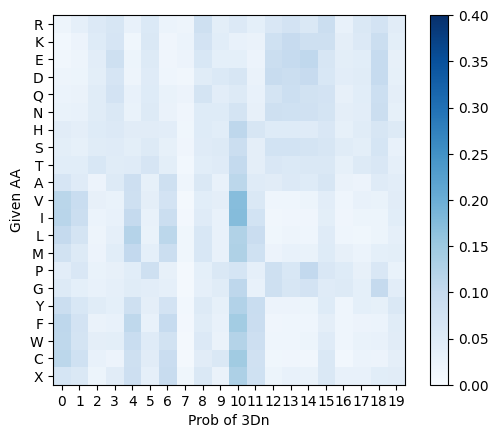

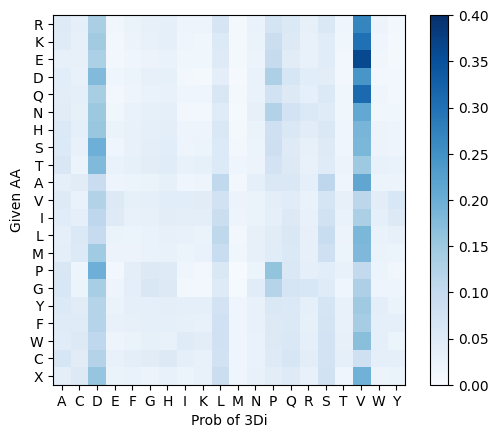

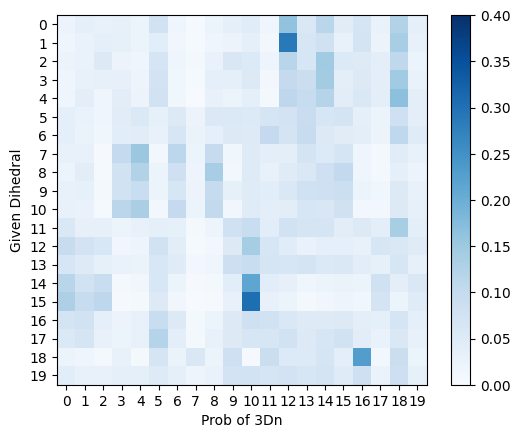

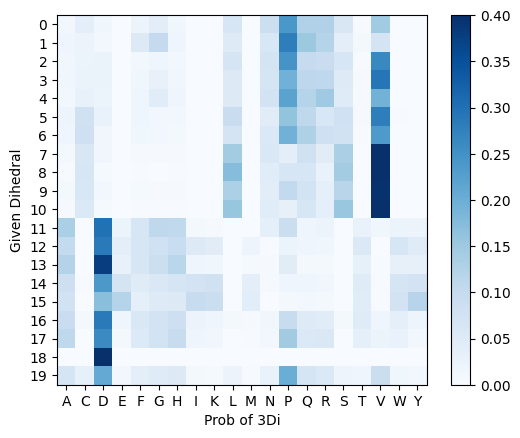

In [17]:

ub = .4
plt.imshow((NA_counts/np.sum(NA_counts, axis =0)).T[aa_permutation,:],cmap = 'Blues', vmin = 0, vmax = ub)
plt.ylabel("Given AA")
plt.xlabel("Prob of 3Dn")
plt.yticks(ticks=np.arange(len(AA_labels)), labels=AA_property_order)
plt.xticks(ticks=np.arange(len(num_labels)), labels=num_labels)
plt.colorbar()
plt.show()

plt.imshow((IA_counts/np.sum(IA_counts, axis =0)).T[aa_permutation,:],cmap = 'Blues', vmin = 0, vmax = ub)
plt.ylabel("Given AA")
plt.xlabel("Prob of 3Di")
plt.yticks(ticks=np.arange(len(AA_labels)), labels=AA_property_order)
plt.xticks(ticks=np.arange(len(num_labels)), labels=ThreeDi_labels)
plt.colorbar()
plt.show()

plt.imshow((ND_counts/np.sum(ND_counts, axis =0)).T[dihedral_permutation,:],cmap = 'Blues', vmin = 0, vmax = ub)
plt.ylabel("Given Dihedral")
plt.xlabel("Prob of 3Dn")
plt.yticks(ticks=np.arange(len(num_labels)), labels=num_labels)
plt.xticks(ticks=np.arange(len(num_labels)), labels=num_labels)
plt.colorbar()
plt.show()

plt.imshow((ID_counts/np.sum(ID_counts, axis =0)).T[dihedral_permutation,:],cmap = 'Blues', vmin = 0, vmax = ub)
plt.ylabel("Given Dihedral")
plt.xlabel("Prob of 3Di")
plt.yticks(ticks=np.arange(len(num_labels)), labels=num_labels)
plt.xticks(ticks=np.arange(len(num_labels)), labels=ThreeDi_labels)
plt.colorbar()
plt.show()

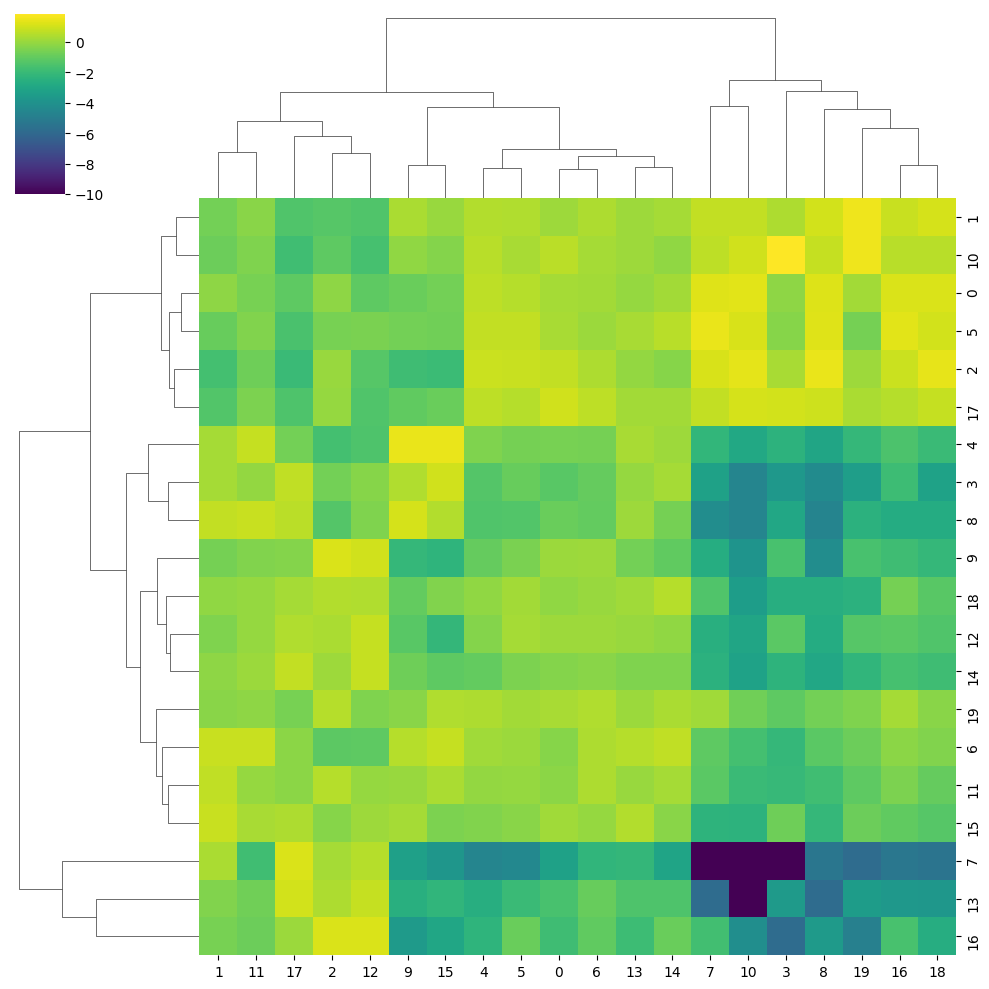

In [18]:
cluster_grid = sns.clustermap(NI_lo, cmap='viridis', row_cluster=True, col_cluster=True)

# Get the reordered indices for rows and columns
reordered_row_indices = cluster_grid.dendrogram_row.reordered_ind
reordered_col_indices = cluster_grid.dendrogram_col.reordered_ind

# Extract the reordered matrix using array indexing
reordered_NI_lo = NI_lo[reordered_row_indices, :][:, reordered_col_indices]

# Get the reordered labels for rows and columns
reordered_row_labels = [i for i in reordered_row_indices]
reordered_col_labels = [ThreeDi_labels[i] for i in reordered_col_indices]




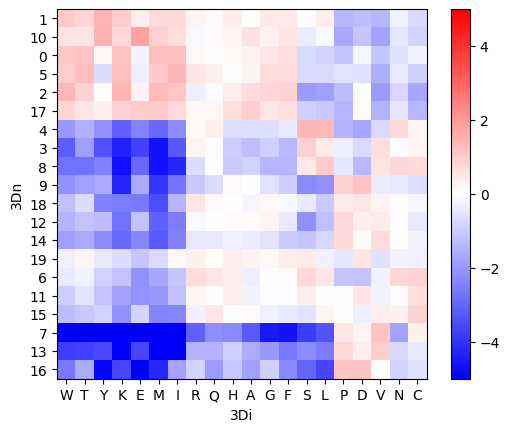

In [19]:
# Plot the heatmap with labels
plt.imshow(reordered_NI_lo[:,::-1], cmap='bwr', vmin = -5, vmax = 5)
plt.xlabel("3Di")
plt.ylabel("3Dn")
plt.yticks(ticks=np.arange(len(num_labels)), labels=reordered_row_labels)
plt.xticks(ticks=np.arange(len(num_labels)), labels=reordered_col_labels[::-1])
plt.colorbar()
plt.show()
